## Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RepeatedKFold
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error
from yellowbrick.regressor import PredictionError, ResidualsPlot
import matplotlib.pyplot as plt
import seaborn as sns

## Define the files to be loaded

In [2]:
# Participant number whose data should be loaded
participant_number = 2

# The version of the questionnaires to load
quest_version = 2

## Loading the pre-processed data

In [3]:
df = pd.read_csv('data/preprocessed/preprocessed_data_' + str(participant_number) + '_v' + str(quest_version) + '.csv')
df = df.drop(labels=['actual_day', 'actual_day.1'], axis=1)

df_oura = pd.read_csv('data/preprocessed/preprocessed_sleep_' + str(participant_number) + '_v' + str(quest_version) + '.csv')
df_oura = df_oura.drop(labels=['actual_day'], axis=1)

df_quest = pd.read_csv('data/preprocessed/preprocessed_questionnaires_' + str(participant_number) + '_v' + str(quest_version) + '.csv')
df_quest = df_quest.drop(labels=['actual_day'], axis=1)

In [4]:
# Remove these to try and fix the issues raised by LazyRegressor for them 
# example: 
# AdaBoostRegressor model failed to execute
# Found unknown categories ['[0.0, 51.0, 53.0, 53.0, 54.0, 53.0, ...
df = df.drop(labels=['hrv.items', 'heart_rate.items', 'sleep_phase_5_min', 'movement_30_sec', 'segment_state', 'type'], axis=1)
df_oura = df_oura.drop(labels=['hrv.items', 'heart_rate.items', 'sleep_phase_5_min', 'movement_30_sec', 'segment_state', 'type'], axis=1)

In [5]:
# Replace NaN values by 999 because NaN values can raise errors when fed to a regression model
df.fillna(999, inplace=True)
df_oura.fillna(999, inplace=True)
df_quest.fillna(999, inplace=True)

In [6]:
# Check for variables whose values are stored as string. This cannot be analyzed by the regression model
for i in range(len(df.columns)):
    if isinstance(df.iloc[1,i], str):
        print('column ' + df.columns[i])
        print('     ' + df.iloc[1,i])

## Define the analysis to be done

In [7]:
# For Oura sleep score
variable_of_interest = 'score'
oura_drop_variables = ['score']
quest_drop_variables = ['subjective_sleep_score']

# For Oura sleep score
# variable_of_interest = 'subjective_sleep_score'
# oura_drop_variables = ['score']
# quest_drop_variables = ['subjective_sleep_score']

# # For average HRV
# variable_of_interest = 'average_hrv'
# oura_drop_variables = ['average_hrv']
# quest_drop_variables = []

## Apply Lasso

### Setting the data to be evaluated

In [8]:
# Separate the indenpendent variables from the dependent variables
y = df[variable_of_interest]
X = df.drop(labels=oura_drop_variables+quest_drop_variables, axis=1)
X_oura = df_oura.drop(labels=oura_drop_variables, axis=1)
X_quest = df_quest.drop(labels=quest_drop_variables, axis=1)

### Defining the Lasso model

In [9]:
def lasso_model(X, y, random_state):
    # Define model evaluation method
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

    # Splitting train and test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = random_state)

    # Define model
    alphas = np.arange(0.01, 5, 0.01)
    model = LassoCV(alphas=alphas, cv=cv, max_iter=10000)

    model.fit(X_train, y_train)

    # Print search results
    print('Lasso CV results\nBest alpha value: %s\n' % model.alpha_)

    print("Number of coefficients", len(model.coef_))
    print("Non-zero coeffcients", np.count_nonzero(model.coef_))
    print("Coefficients", model.coef_)
    return model, X_train, X_test, y_train, y_test 

In [10]:
# Compute R squared and mean square error of a given model and training and testing sets 
def compute_model(model, X_train, y_train, X_test, y_test):
    # Training data
    print('R squared training set', round(model.score(X_train, y_train), 3))
    pred_train = model.predict(X_train)
    mse_train = mean_squared_error(y_train, pred_train)
    print('MSE training set', round(mse_train, 3))

    # Test data
    print('\nR squared test set', round(model.score(X_test, y_test), 3))
    pred_test = model.predict(X_test)
    mse_test = mean_squared_error(y_test, pred_test)
    print('MSE test set', round(mse_test, 3))

    return pred_train, pred_test

### Using as independent variables all variables (Oura + questionnaire data)

In [11]:
reg, X_train, X_test, y_train, y_test = lasso_model(X, y, random_state=np.random.randint(50000))

/Users/user/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.911e-03, tolerance: 3.997e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/Users/user/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.238e-03, tolerance: 3.259e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/Users/user/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might wan

Lasso CV results
Best alpha value: 0.01

Number of coefficients 78
Non-zero coeffcients 32
Coefficients [ 0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -1.05817869e-04 -1.04256119e-04  8.23274590e-05  2.60751247e-17
 -1.06600983e-04 -1.69806989e-17  4.95794008e-03  0.00000000e+00
  7.24039911e-03  7.83414389e-03  1.21218287e-02  5.09126241e-03
  3.06421434e-02 -5.12916542e-05  0.00000000e+00  0.00000000e+00
  1.10066078e-04 -6.05932710e-05  0.00000000e+00 -1.14412522e-06
 -0.00000000e+00  1.43415056e-05 -0.00000000e+00 -0.00000000e+00
  6.85561558e-05  6.52765748e-03 -5.97218705e-04 -1.21608130e-05
 -7.57523380e-05 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -5.07348326e-05 -0.00000000e+00 -0.00000000e+00 -6.57615819e-05
 -1.37248624e-05 -2.76969443e-04  1.67276619e-05 -0.00000000e+00
 -2.52902683e-04  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0

In [12]:
pred_train, pred_test = compute_model(reg, X_train, y_train, X_test, y_test)

R squared training set 0.999
MSE training set 0.001

R squared test set 0.985
MSE test set 0.004


In [13]:
selected_features = []
for i in range(len(reg.coef_)):
    if reg.coef_[i] != 0:
        selected_features.append(X_train.columns[i])

print('Number of selected features', len(selected_features))
selected_features

Number of selected features 32


['average_hrv',
 'awake_time',
 'bedtime_end_delta',
 'bedtime_end_seconds',
 'bedtime_start_delta',
 'bedtime_start_seconds',
 'contributors.deep_sleep',
 'contributors.latency',
 'contributors.rem_sleep',
 'contributors.restfulness',
 'contributors.timing',
 'contributors.total_sleep',
 'deep_sleep_duration',
 'latency',
 'light_sleep_duration',
 'lowest_heart_rate_time_offset',
 'readiness.contributors.activity_balance',
 'readiness.contributors.previous_day_activity',
 'readiness.contributors.previous_night',
 'readiness.contributors.recovery_index',
 'readiness.contributors.resting_heart_rate',
 'readiness.contributors.sleep_balance',
 'rem_sleep_duration',
 'sleep_midpoint',
 'time_in_bed',
 'timezone',
 'total_sleep_duration',
 'prev_oura_score',
 'prev_subjective_score',
 'alcohol_time',
 'coffee_time',
 'workout_intensity']

In [14]:
# Print the equation of how to predict the variable according to the model
def print_equation(model, X_train):
    counter = 0
    equation = ''
    for i in range(len(model.coef_)):
        if model.coef_[i] != 0:
            if counter != 0:
                equation += ' + '
            else:
                counter += 1
            equation += '(' + str(round(model.coef_[i], 5)) + ' * ' + X_train.columns[i] + ')'
    print(equation)

In [15]:
print_equation(reg, X_train)

(-0.00011 * average_hrv) + (-0.0001 * awake_time) + (8e-05 * bedtime_end_delta) + (0.0 * bedtime_end_seconds) + (-0.00011 * bedtime_start_delta) + (-0.0 * bedtime_start_seconds) + (0.00496 * contributors.deep_sleep) + (0.00724 * contributors.latency) + (0.00783 * contributors.rem_sleep) + (0.01212 * contributors.restfulness) + (0.00509 * contributors.timing) + (0.03064 * contributors.total_sleep) + (-5e-05 * deep_sleep_duration) + (0.00011 * latency) + (-6e-05 * light_sleep_duration) + (-0.0 * lowest_heart_rate_time_offset) + (1e-05 * readiness.contributors.activity_balance) + (7e-05 * readiness.contributors.previous_day_activity) + (0.00653 * readiness.contributors.previous_night) + (-0.0006 * readiness.contributors.recovery_index) + (-1e-05 * readiness.contributors.resting_heart_rate) + (-8e-05 * readiness.contributors.sleep_balance) + (-5e-05 * rem_sleep_duration) + (-7e-05 * sleep_midpoint) + (-1e-05 * time_in_bed) + (-0.00028 * timezone) + (2e-05 * total_sleep_duration) + (-0.0002

### Visualizing the results
#### Plotting the actual test data points against the predicted data point

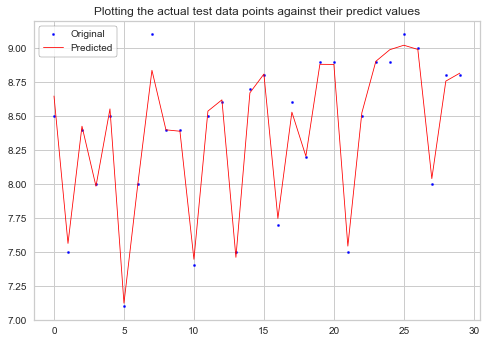

In [16]:
plt.style.use("seaborn-notebook")

x_ax = range(len(X_test))
plt.scatter(x_ax, y_test, s=5, color="blue", label="Original")
plt.plot(x_ax, pred_test, lw=0.8, color="red", label="Predicted")
plt.title("Plotting the actual test data points against their predict values")
plt.legend(frameon=True, loc='best').get_frame().set_edgecolor('k')
plt.show()

#### Plotting the actual train data points against the predicted data point

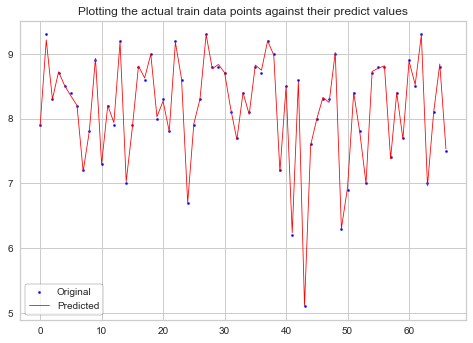

In [17]:
x_ax = range(len(X_train))
plt.scatter(x_ax, y_train, s=5, color="blue", label="Original")
plt.plot(x_ax, pred_train, lw=0.8, color="red", label="Predicted")
plt.title("Plotting the actual train data points against their predict values")
plt.legend(frameon=True, loc='best').get_frame().set_edgecolor('k')
plt.show()

#### How off the predicted values were for the test set

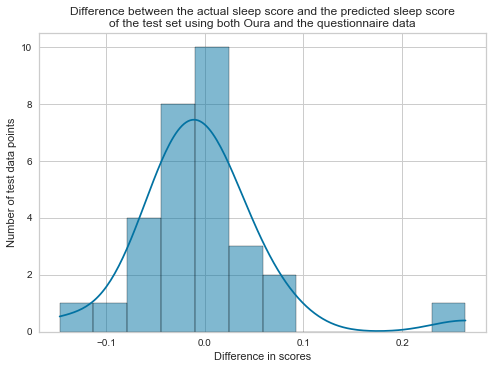

In [18]:
ax = sns.histplot(y_test-pred_test, kde=True)
ax.set(xlabel='Difference in scores', ylabel='Number of test data points', 
       title='Difference between the actual sleep score and the predicted sleep score\nof the test set using both Oura and the questionnaire data')
plt.show()

#### Prediction error plot
It plots the actual targets from the dataset against the predicted values generated by the Lasso model, thereby showing how much variance is in the model.

/Users/user/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LassoCV was fitted with feature names
  "X does not have valid feature names, but"


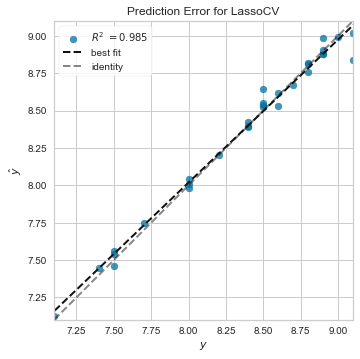

<AxesSubplot:title={'center':'Prediction Error for LassoCV'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [19]:
visualizer = PredictionError(reg)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
visualizer.poof()

#### Residuals plot
Residuals are the difference between the true value of the target variable and the predicted value. Thus, it is the error of the prediction. The difference between residuals is shown in a residuals plot, plotted against the predicted dependent variables along with the distribution of residuals.

/Users/user/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LassoCV was fitted with feature names
  "X does not have valid feature names, but"


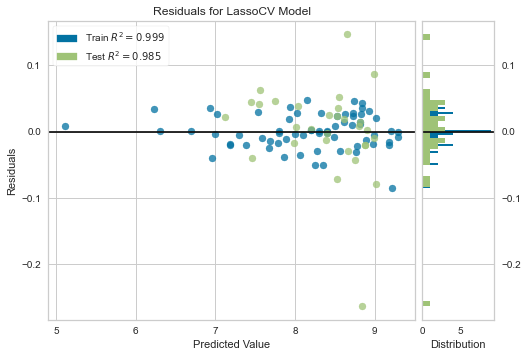

<AxesSubplot:title={'center':'Residuals for LassoCV Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [20]:
visualizer = ResidualsPlot(reg)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
visualizer.poof()

## Using as independent variables only the Oura data
### Lasso

In [21]:
reg_oura, X_train_oura, X_test_oura, y_train_oura, y_test_oura = lasso_model(X_oura, y, random_state=995)

/Users/user/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005224833921856402, tolerance: 0.003426183333333334
  positive,
/Users/user/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012039437489098623, tolerance: 0.003248733333333334
  positive,
/Users/user/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007364255599480896, tolerance: 0.0030649833333333343
  positive,
/Users/user/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/linear_m

Lasso CV results
Best alpha value: 0.01

Number of coefficients 47
Non-zero coeffcients 28
Coefficients [-5.67364859e-05  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00  1.33962066e-04 -7.90158165e-05  8.54912923e-05
  2.23090909e-21 -1.04233953e-04 -6.10245620e-18  5.60206296e-03
  0.00000000e+00  6.68534133e-03  8.83903364e-03  1.20644168e-02
  5.73053065e-03  2.78850687e-02 -4.09860742e-05  0.00000000e+00
  0.00000000e+00  8.47442812e-05 -5.15681402e-05 -0.00000000e+00
 -1.96373571e-06 -0.00000000e+00  2.04843965e-04 -0.00000000e+00
 -1.79191330e-04  0.00000000e+00  7.40621362e-03 -4.71223724e-04
 -4.39726103e-04 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -5.77742650e-05  0.00000000e+00 -0.00000000e+00
 -9.86507874e-06 -4.65173908e-05  1.17250265e-05  1.90396087e-05
 -0.00000000e+00 -3.12053947e-04 -0.00000000e+00]


/Users/user/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0072772170407914005, tolerance: 0.0028622295081967225
  positive,


In [22]:
pred_train_oura, pred_test_oura = compute_model(reg_oura, X_train_oura, y_train_oura, X_test_oura, y_test_oura)

R squared training set 0.999
MSE training set 0.001

R squared test set 0.992
MSE test set 0.005


In [23]:
print_equation(reg_oura, X_train_oura)

(-6e-05 * index) + (0.00013 * average_hrv) + (-8e-05 * awake_time) + (9e-05 * bedtime_end_delta) + (0.0 * bedtime_end_seconds) + (-0.0001 * bedtime_start_delta) + (-0.0 * bedtime_start_seconds) + (0.0056 * contributors.deep_sleep) + (0.00669 * contributors.latency) + (0.00884 * contributors.rem_sleep) + (0.01206 * contributors.restfulness) + (0.00573 * contributors.timing) + (0.02789 * contributors.total_sleep) + (-4e-05 * deep_sleep_duration) + (8e-05 * latency) + (-5e-05 * light_sleep_duration) + (-0.0 * lowest_heart_rate_time_offset) + (0.0002 * readiness.contributors.activity_balance) + (-0.00018 * readiness.contributors.hrv_balance) + (0.00741 * readiness.contributors.previous_night) + (-0.00047 * readiness.contributors.recovery_index) + (-0.00044 * readiness.contributors.resting_heart_rate) + (-6e-05 * rem_sleep_duration) + (-1e-05 * sleep_midpoint) + (-5e-05 * time_in_bed) + (1e-05 * timezone) + (2e-05 * total_sleep_duration) + (-0.00031 * prev_oura_score)


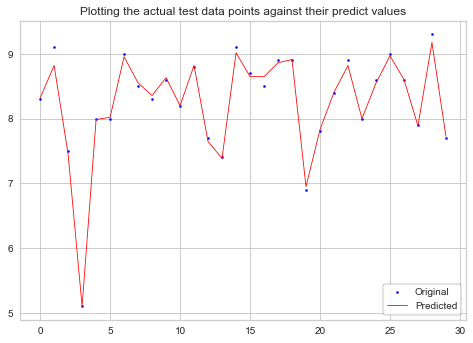

In [24]:
plt.style.use("seaborn-notebook")

# Visualization of the actual test data points vs the precited ones
x_ax = range(len(X_test_oura))
plt.scatter(x_ax, y_test_oura, s=5, color="blue", label="Original")
plt.plot(x_ax, pred_test_oura, lw=0.8, color="red", label="Predicted")
plt.title("Plotting the actual test data points against their predict values")
plt.legend(frameon=True, loc='best').get_frame().set_edgecolor('k')
plt.show()

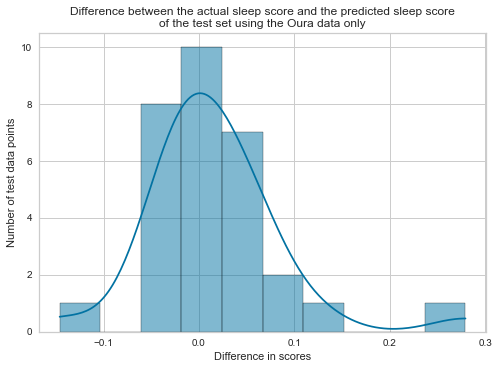

In [25]:
# How off the predicted values were for the test set
ax = sns.histplot(y_test_oura-pred_test_oura, kde=True)
ax.set(xlabel='Difference in scores', ylabel='Number of test data points', 
       title='Difference between the actual sleep score and the predicted sleep score\nof the test set using the Oura data only')
plt.show()

/Users/user/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LassoCV was fitted with feature names
  "X does not have valid feature names, but"


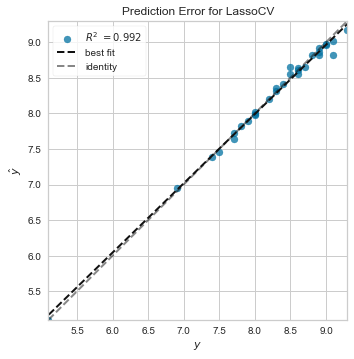

<AxesSubplot:title={'center':'Prediction Error for LassoCV'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [26]:
# Prediction Error Plot
visualizer = PredictionError(reg_oura)
visualizer.fit(X_train_oura, y_train_oura)  
visualizer.score(X_test_oura, y_test_oura)  
visualizer.poof()

/Users/user/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LassoCV was fitted with feature names
  "X does not have valid feature names, but"


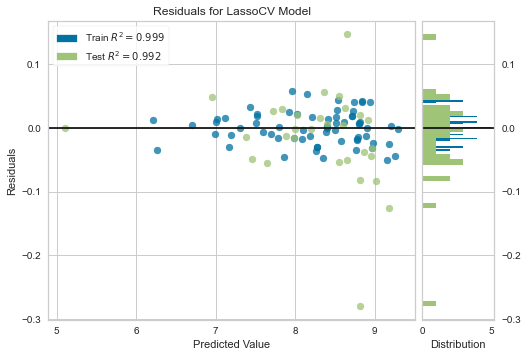

<AxesSubplot:title={'center':'Residuals for LassoCV Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [27]:
# Residuals Plot
visualizer = ResidualsPlot(reg_oura)
visualizer.fit(X_train_oura, y_train_oura)  
visualizer.score(X_test_oura, y_test_oura)  
visualizer.poof()

## Applying the same model on the questionnaire data only
### Lasso

In [28]:
reg_quest, X_train_quest, X_test_quest, y_train_quest, y_test_quest = lasso_model(X_quest, y, random_state=995)

/Users/user/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07459916062628125, tolerance: 0.003154983333333334
  positive,
/Users/user/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.39198144894120546, tolerance: 0.003154983333333334
  positive,
/Users/user/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7540090255334491, tolerance: 0.003154983333333334
  positive,
/Users/user/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/linear_model/

Lasso CV results
Best alpha value: 0.02

Number of coefficients 33
Non-zero coeffcients 12
Coefficients [-6.16201574e-03 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -4.43265087e-01  0.00000000e+00
  0.00000000e+00  3.24198120e-04  0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -1.12826272e-01 -7.19219872e-01 -4.97018788e-02
 -7.42442806e-05  0.00000000e+00 -6.21090859e-06  9.40585741e-02
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00  5.58933678e-02  0.00000000e+00 -5.42748207e-03
  5.21105189e-03]


/Users/user/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.14361839341876248, tolerance: 0.0028622295081967225
  positive,
/Users/user/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.45069063503677675, tolerance: 0.0028622295081967225
  positive,
/Users/user/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9341497189793753, tolerance: 0.0028622295081967225
  positive,
/Users/user/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/linear_mod

In [29]:
pred_train_quest, pred_test_quest = compute_model(reg_quest, X_train_quest, y_train_quest, X_test_quest, y_test_quest)

R squared training set 0.568
MSE training set 0.226

R squared test set 0.372
MSE test set 0.421


In [30]:
print_equation(reg_quest, X_train_quest)

(-0.00616 * index) + (-0.44327 * prevent_early_sleep) + (0.00032 * prev_subjective_score) + (-0.11283 * Socially active) + (-0.71922 * Stressful) + (-0.0497 * alcohol_amount) + (-7e-05 * alcohol_time) + (-1e-05 * coffee_time) + (0.09406 * eat_bedtime) + (0.05589 * stress_levels) + (-0.00543 * workout_intensity) + (0.00521 * workout_time)


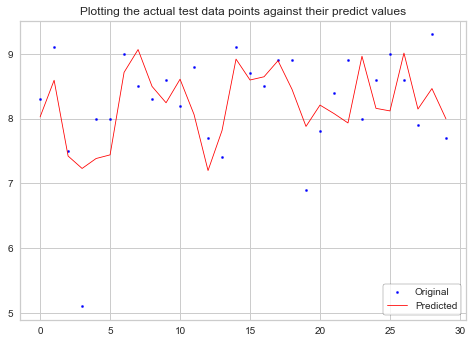

In [31]:
plt.style.use("seaborn-notebook")

# Visualization of the actual test data points vs the precited ones
x_ax = range(len(X_test_quest))
plt.scatter(x_ax, y_test_quest, s=5, color="blue", label="Original")
plt.plot(x_ax, pred_test_quest, lw=0.8, color="red", label="Predicted")
plt.title("Plotting the actual test data points against their predict values")
plt.legend(frameon=True, loc='best').get_frame().set_edgecolor('k')
plt.show()

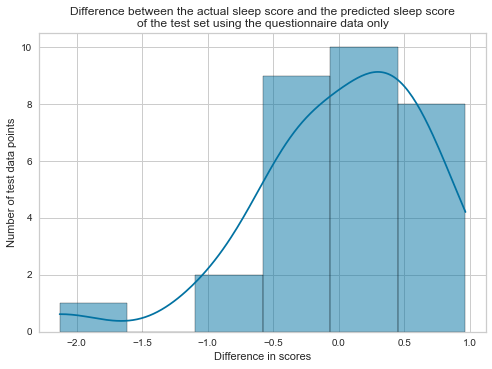

In [32]:
# How off the predicted values were for the test set
ax = sns.histplot(y_test_quest-pred_test_quest, kde=True)
ax.set(xlabel='Difference in scores', ylabel='Number of test data points', 
       title='Difference between the actual sleep score and the predicted sleep score\nof the test set using the questionnaire data only')
plt.show()

/Users/user/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LassoCV was fitted with feature names
  "X does not have valid feature names, but"


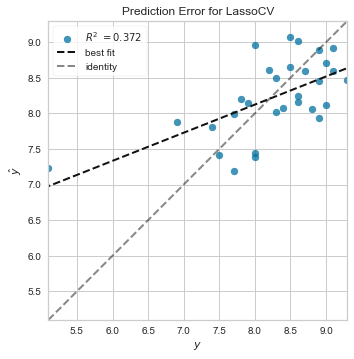

<AxesSubplot:title={'center':'Prediction Error for LassoCV'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [33]:
# Prediction Error Plot
visualizer = PredictionError(reg_quest)
visualizer.fit(X_train_quest, y_train_quest)  
visualizer.score(X_test_quest, y_test_quest)  
visualizer.poof()

/Users/user/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LassoCV was fitted with feature names
  "X does not have valid feature names, but"


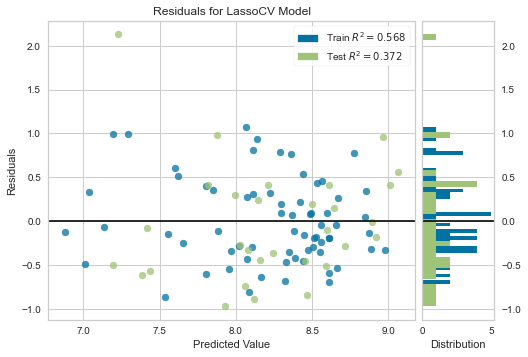

<AxesSubplot:title={'center':'Residuals for LassoCV Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [34]:
# Residuals Plot
visualizer = ResidualsPlot(reg_quest)
visualizer.fit(X_train_quest, y_train_quest)  
visualizer.score(X_test_quest, y_test_quest)  
visualizer.poof()